# Book-Crossing Dataset

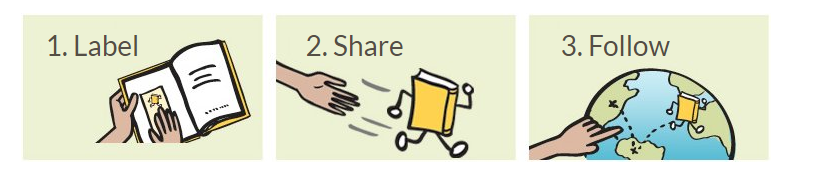

In [18]:
from IPython.display import Image
Image(filename='Capture.PNG')

## What is BookCrossing?
BookCrossing is the act of releasing your books "into the wild" for a stranger to find, or via "controlled release" to another BookCrossing member, and tracking where they go via journal entries from around the world.

Data is collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the [Book-Crossing](http://www.bookcrossing.com/) community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

## Format
The Book-Crossing dataset comprises 3 tables.
- __BX-Users__:

Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.

- __BX-Books__:

Books are identified by their respective International Standard Book Number(ISBN). Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.

- __BX-Book-Ratings__:

Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### Preliminaries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from collections import Counter
import string
import re

import warnings
warnings.filterwarnings("ignore")

### Loading Data

__BX-Users__

In [20]:
users_cols = ['userID', 'Location', 'Age']
users = pd.read_csv('BX-Users.csv', sep=';',names=users_cols,skiprows=1,error_bad_lines=False, encoding="latin-1",low_memory=False)
print('Shape of User data:{}'.format(users.shape))
users.head()

Shape of User data:(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


__BX-Books__

In [21]:
books_cols = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
books = pd.read_csv('BX-Books.csv',sep=';',names=books_cols,encoding='latin-1',skiprows=1,error_bad_lines=False)
print('Shape of Books data:{}'.format(books.shape))
books.head()

Shape of Books data:(271379, 8)


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


__BX-Book-Ratings__

In [22]:
ratings_cols = ['userID', 'ISBN', 'bookRating']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';',names=ratings_cols,skiprows=1,error_bad_lines=False, encoding="latin-1",low_memory=False)
print('Shape of Book-Ratings data:{}'.format(ratings.shape))
ratings.head()

Shape of Book-Ratings data:(1149780, 3)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


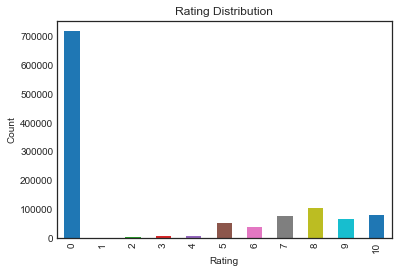

In [23]:
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.rc('font',size=10)
plt.savefig('rating_distribution.png', bbox_inches='tight');

In [24]:
print(ratings.bookRating.value_counts(sort=False))

0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: bookRating, dtype: int64


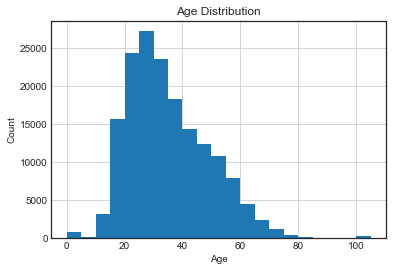

In [25]:
users.Age.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.rc('font',size=10)
plt.savefig('age_distribution.png', bbox_inches='tight');

In [26]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
rating_count.sort_values('bookRating', ascending=False).head()

,bookRating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


In [27]:
books[books['ISBN'] == "0971880107"]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...


In [28]:
top5_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'],index=np.arange(5),columns = ['ISBN'])
top5_rated_books_summary = pd.merge(top5_rated_books, books, on='ISBN')
top5_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


In [29]:
avg_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
avg_rating['ratingCount'] = rating_count
avg_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


In [30]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

In [31]:
ratings.shape

(527556, 3)

In [32]:
user_ratings_matrix = ratings.pivot_table(index='userID', columns='ISBN',values='bookRating')
print('Shape of User Ratings Matrix is {}'.format(user_ratings_matrix.shape))
user_ratings_matrix.head()

Shape of User Ratings Matrix is (905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
hp_ratings  = user_ratings_matrix['059035342X']
similar_to_hp = user_ratings_matrix.corrwith(hp_ratings)
corr_hp = pd.DataFrame(similar_to_hp, columns=['pearsonR'])
corr_hp .dropna(inplace=True)
corr_summary = corr_hp.join(avg_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(6)

,pearsonR,ratingCount
ISBN,,
059035342X,1.000000,571
0439064872,0.519776,351
0671003755,0.463279,446
006101351X,0.454423,364
0671510053,0.433417,349
044651652X,0.423662,368


In [37]:
books_corr_to_hp = pd.DataFrame(['0439064872','0671003755', 
                                    '006101351X','0671510053', 
                                    '044651652X'],index=np.arange(5), columns=['ISBN'])
recommended_books = pd.merge(books_corr_to_hp, books, on='ISBN')
recommended_books 

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...
1,0671003755,She's Come Undone (Oprah's Book Club (Paperback)),Wally Lamb,1996,Washington Square Press,http://images.amazon.com/images/P/0671003755.0...,http://images.amazon.com/images/P/0671003755.0...,http://images.amazon.com/images/P/0671003755.0...
2,006101351X,The Perfect Storm : A True Story of Men Agains...,Sebastian Junger,1998,HarperTorch,http://images.amazon.com/images/P/006101351X.0...,http://images.amazon.com/images/P/006101351X.0...,http://images.amazon.com/images/P/006101351X.0...
3,0671510053,SHIPPING NEWS,Annie Proulx,1994,Scribner,http://images.amazon.com/images/P/0671510053.0...,http://images.amazon.com/images/P/0671510053.0...,http://images.amazon.com/images/P/0671510053.0...
4,044651652X,The Bridges of Madison County,Robert James Waller,1992,Warner Books,http://images.amazon.com/images/P/044651652X.0...,http://images.amazon.com/images/P/044651652X.0...,http://images.amazon.com/images/P/044651652X.0...
